## 01 IMPORTS

In [1]:
import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

print("Project root añadido a sys.path:")
print(PROJECT_ROOT)

Project root añadido a sys.path:
c:\Users\Rodrigo\Desktop\pontia\evaluacion_LLMs\evaluacion_LLMs


In [2]:
import os
from dotenv import load_dotenv

load_dotenv()  # carga .env

# Local modules
from src.rag import build_rag_index, save_rag_index, load_rag_index, retrieve, format_context
from src.llm import chat, extract_text, extract_tool_calls
from src.tools import get_tools_schema, run_tool, weather_result_to_text
from src.memory import ChatMemory


## 02 Config y paths

In [3]:
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))  # desde notebooks/ a raíz
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

GUIDE_PATH = os.path.join(DATA_DIR, "TENERIFE.pdf")
INDEX_DIR = os.path.join(DATA_DIR, "index_faiss")

print("GUIDE_PATH =", GUIDE_PATH)
print("Existe GUIDE_PATH?:", os.path.exists(GUIDE_PATH))


TOP_K = int(os.getenv("TOP_K", "5"))


GUIDE_PATH = c:\Users\Rodrigo\Desktop\pontia\evaluacion_LLMs\evaluacion_LLMs\data\TENERIFE.pdf
Existe GUIDE_PATH?: True


## 03 Construir/cargar índice RAG

In [4]:
import os

if os.path.exists(os.path.join(INDEX_DIR, "faiss.index")) and os.path.exists(os.path.join(INDEX_DIR, "chunks.json")):
    rag = load_rag_index(INDEX_DIR)
    print("✅ Índice FAISS cargado:", INDEX_DIR)
else:
    rag = build_rag_index(GUIDE_PATH)
    os.makedirs(INDEX_DIR, exist_ok=True)
    save_rag_index(rag, INDEX_DIR)
    print("✅ Índice FAISS creado y guardado en:", INDEX_DIR)

print("Chunks:", len(rag.chunks), "| Dim:", rag.dim, "| Embeddings model:", rag.embed_model)


✅ Índice FAISS cargado: c:\Users\Rodrigo\Desktop\pontia\evaluacion_LLMs\evaluacion_LLMs\data\index_faiss
Chunks: 35 | Dim: 1536 | Embeddings model: text-embedding-3-small


## 04 Memoria de conversación

In [5]:
mem = ChatMemory(
    system_prompt=(
        "Eres un asistente turístico. Responde en español. "
        "Usa el CONTEXTO proporcionado para contestar y cita las fuentes con los ids/páginas "
        "cuando uses información de la guía. "
        "Si necesitas el tiempo para una fecha, llama a la herramienta get_weather."
    ),
    max_turns=8,
    max_chars=12000
)

TOOLS = get_tools_schema()

## 05 Helper para construir prompt con RAG

In [6]:
def build_user_prompt(user_msg: str, rag_context: str) -> str:
    return (
        "CONTEXTO (extractos de la guía; cita usando el id entre corchetes):\n"
        f"{rag_context}\n\n"
        "PREGUNTA DEL USUARIO:\n"
        f"{user_msg}\n\n"
        "INSTRUCCIONES:\n"
        "- Si el contexto contiene la respuesta, úsalo y cita [id | pág. X].\n"
        "- Si el contexto no es suficiente, dilo claramente y sugiere qué faltaría.\n"
        "- Si te preguntan por el tiempo en una fecha concreta, usa get_weather(fecha).\n"
    )

## 06 Orquestador principal answer() (con tool calling)

In [7]:
def answer(user_msg: str, *, top_k: int = TOP_K, verbose: bool = True) -> str:
    # 1) RAG retrieve
    chunks = retrieve(rag, user_msg, top_k=top_k)
    context = format_context(chunks)

    # 2) Añadir el turno del usuario (con contexto “inyectado”)
    mem.add_user(build_user_prompt(user_msg, context))

    # 3) Primera llamada al LLM con tools habilitadas
    resp1 = chat(mem.get_messages(), tools=TOOLS, tool_choice="auto")
    tool_calls = extract_tool_calls(resp1)

    # Si no hay tool calls, devolvemos el texto
    if not tool_calls:
        text = extract_text(resp1)
        mem.add_assistant(text)
        if verbose:
            print(text)
        return text

    # 4) Ejecutar tool calls (pueden ser múltiples)
    tool_summaries = []
    for call in tool_calls:
        name = call.get("name")
        arguments = call.get("arguments")
        out = run_tool(name, arguments)
        summary = weather_result_to_text(out) if name == "get_weather" else str(out)
        tool_summaries.append(f"[Resultado de {name}] {summary}")

    # 5) Meter resultado de tool en memoria
    tool_block = "\n".join(tool_summaries)
    mem.add_tool_result(tool_block)

    # 6) Segunda llamada al LLM para redactar respuesta final (ya con tool result en contexto)
    resp2 = chat(mem.get_messages(), tools=TOOLS, tool_choice="auto")
    final_text = extract_text(resp2)

    mem.add_assistant(final_text)
    if verbose:
        print(final_text)
    return final_text


## 07 Probar conversación multiturno (demo)

In [10]:
print("Quiero un plan de 1 día con cosas típicas para ver. ¿Qué recomiendas?")
answer("Quiero un plan de 1 día con cosas típicas para ver. ¿Qué recomiendas?")

print("Genial. Y para mañana seis de enero del 2026, ¿qué tiempo hará? (usa la fecha en formato YYYY-MM-DD)")
answer("Genial. Y para mañana, ¿qué tiempo hará? (usa la fecha en formato YYYY-MM-DD)")

print("Incluye algún museo mencionado en la guía y dime por qué vale la pena.")
answer("Incluye algún museo mencionado en la guía y dime por qué vale la pena.")


Quiero un plan de 1 día con cosas típicas para ver. ¿Qué recomiendas?
Para consultar el tiempo, por favor proporciona la fecha en formato YYYY-MM-DD.
Genial. Y para mañana seis de enero del 2026, ¿qué tiempo hará? (usa la fecha en formato YYYY-MM-DD)
Por favor, proporciona la fecha en formato YYYY-MM-DD para poder consultar el tiempo para mañana.
Incluye algún museo mencionado en la guía y dime por qué vale la pena.
El contexto proporcionado no menciona ningún museo específico. Para incluir un museo en tu itinerario, necesitaría más información sobre museos en Tenerife. Si deseas, puedo ayudarte a buscar información adicional sobre museos en la isla.


'El contexto proporcionado no menciona ningún museo específico. Para incluir un museo en tu itinerario, necesitaría más información sobre museos en Tenerife. Si deseas, puedo ayudarte a buscar información adicional sobre museos en la isla.'

## 08 Pruebas reproducibles (mini evaluación)

In [14]:
test_prompts = [
    "¿Cuáles son los 3 sitios más importantes según la guía? Cita fuentes.",
    "Dame recomendaciones gastronómicas mencionadas en la guía. Cita fuentes.",
    "¿Qué tiempo hará el 2026-01-06?",
    "Hazme un itinerario de 2 días y menciona qué parte viene de la guía."
]

results = []
for p in test_prompts:
    out = answer(p, verbose=False)
    results.append({"prompt": p, "response": out})

results[:4]


[{'prompt': '¿Cuáles son los 3 sitios más importantes según la guía? Cita fuentes.',
  'response': 'El contexto proporcionado no menciona explícitamente los tres sitios más importantes de Tenerife. Sin embargo, basándome en la información disponible, aquí tienes algunas sugerencias de lugares destacados:\n\n1. **Parque Rural de Anaga**: Un espacio natural protegido con miradores y rutas impresionantes [p5_c001 | pág. 5].\n\n2. **La Laguna**: Un lugar histórico con sitios de interés como la Plaza del Adelantado y la Iglesia de la Concepción [p4_c000 | pág. 4].\n\n3. **Masca**: Conocido por su impresionante barranco y mirador [p22_c000 | pág. 22].\n\nEstos lugares son representativos de la diversidad natural y cultural de Tenerife.'},
 {'prompt': 'Dame recomendaciones gastronómicas mencionadas en la guía. Cita fuentes.',
  'response': 'Aquí tienes algunas recomendaciones gastronómicas mencionadas en la guía:\n\n1. **Terrazas del Sauzal**: Ubicado en El Sauzal, entre La Laguna y La Orotav

## 09 — Métrica simple + gráfico (para el 15%)

In [12]:
import re
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

def count_citations(text: str) -> int:
    if not isinstance(text, str):
        return 0
    # cuenta patrones tipo [p3_c002 | pág. 3] o [p3_c002]
    return len(re.findall(r"\[p\d+_c\d{3}(\s*\|\s*pág\.\s*\d+)?\]", text))

df["citations"] = df["response"].apply(count_citations)
df


,prompt,response,citations
0,¿Cuáles son los 3 sitios más importantes según...,El contexto proporcionado no menciona explícit...,3
1,Dame recomendaciones gastronómicas mencionadas...,Aquí tienes algunas recomendaciones gastronómi...,5
2,¿Qué tiempo hará el 2026-01-06?,,0
3,Hazme un itinerario de 2 días y menciona qué p...,Aquí tienes un itinerario de 2 días en Tenerif...,7


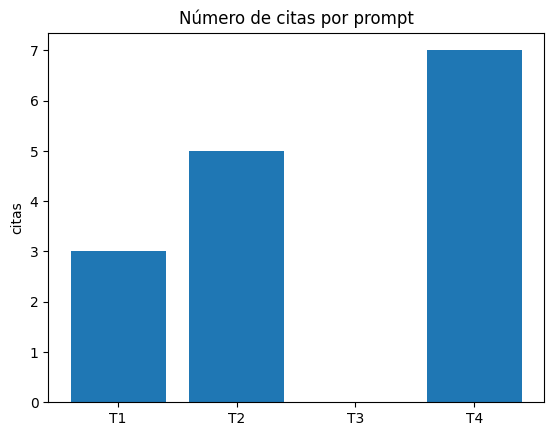

In [13]:
plt.figure()
plt.title("Número de citas por prompt")
plt.bar(range(len(df)), df["citations"])
plt.xticks(range(len(df)), [f"T{i+1}" for i in range(len(df))], rotation=0)
plt.ylabel("citas")
plt.show()


## 10 Chat loop interactivo

In [15]:
print("💬 Chat interactivo (escribe 'salir' para terminar)\n")

while True:
    try:
        user_msg = input("👤 Tú: ").strip()
        if not user_msg:
            continue
        if user_msg.lower() in {"salir", "exit", "quit"}:
            print("👋 Fin del chat.")
            break

        print("🤖 Asistente:")
        answer(user_msg, verbose=True)
        print("-" * 60)

    except KeyboardInterrupt:
        print("\n👋 Chat interrumpido.")
        break

    except Exception as e:
        print(f"⚠️ Error inesperado: {e}")
        break


💬 Chat interactivo (escribe 'salir' para terminar)

🤖 Asistente:
Aquí tienes algunas sugerencias de lugares para visitar en Tenerife, basadas en el contexto de la guía:

1. **Costa Adeje**: Es la zona turística por excelencia, con playas de arena blanca, hoteles de lujo y muchas opciones de ocio como pubs, discotecas y parques acuáticos. No te pierdas el **Siam Park**, considerado el mejor parque acuático del mundo [p16_c000 | pág. 16] [p21_c000 | pág. 21].

2. **Los Gigantes**: Conocido por el Acantilado de Los Gigantes, es un lugar ideal para excursiones en barco para ver delfines y ballenas. También puedes disfrutar de actividades como kayak y motos de agua [p21_c001 | pág. 21].

3. **El Teide**: Puedes subir al pico del Teide usando los teleféricos y disfrutar de uno de los cielos estrellados más espectaculares del mundo [p16_c000 | pág. 16].

4. **Puerto de la Cruz**: Visita el **Loro Parque**, considerado uno de los mejores zoológicos del mundo, y disfruta de las piscinas natural